In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from tqdm import tqdm
import optuna

import torch
from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoDataset, MontevideoFoldersDataset
from src.dl_models.unet import UNet


In [2]:
#Generate csv for cmv for 1 hour
utils.image_sequence_generator_folders(path = 'data/mvd/val/', in_channel=2, out_channel=6, min_time_diff=5, max_time_diff=15, csv_path='data/mvd/val_sequences_in2_out6.csv')

In [2]:
#Test MontevideoDataset
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/' , in_channel = 2, out_channel=6)
val_loader = DataLoader(val_mvd)

for idx, (inputs, target) in enumerate(val_loader):
    inputs = inputs.squeeze()
    target = target.squeeze()
    print(inputs.size())
    print(target.size())
    print(torch.cat((inputs[1:], target)).shape)
    break

torch.Size([2, 256, 256])
torch.Size([6, 256, 256])
torch.Size([7, 256, 256])


Predicting CMV
Status: 100%|██████████| 2488/2488 [01:26<00:00, 28.83sequences/s]
Cmv predict time: 54.90 seconds.
Evaluation time: 8.02 seconds.

Predicting Persistence
Status: 100%|██████████| 2488/2488 [00:16<00:00, 149.79sequences/s]
Persistence predict time: 1.04 seconds.
Evaluation time: 3.76 seconds.
Error_mean_cmv: [ 6.8834743  9.08963   10.727892  11.996362  12.85096   13.536978 ]
Error_mean_p: [ 9.541559 11.529823 12.974996 14.101847 14.861282 15.468912]


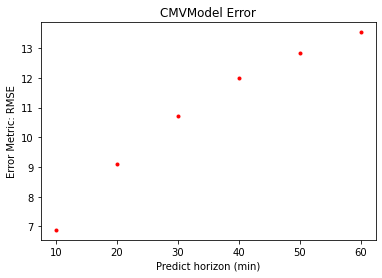

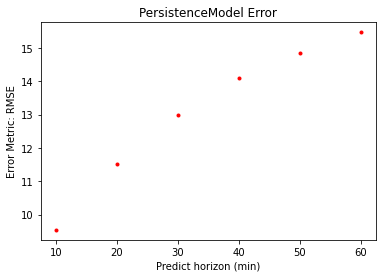

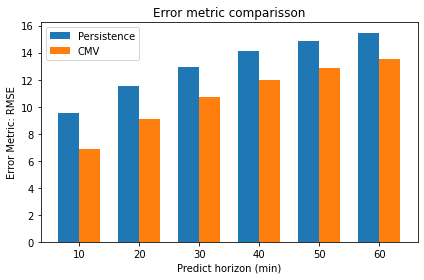

In [4]:
val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/', in_channel = 2, out_channel=6)
val_loader = DataLoader(val_mvd)

cmv = model.Cmv2()
persistence = model.Persistence()
# blurredCMV = model.Cmv2(kernel_size=(21,21))

print('Predicting CMV')
time.sleep(1)
error_array_cmv = evaluate.evaluate_model(cmv, val_loader, 6, metric='RMSE')

print()
print('Predicting Persistence')
time.sleep(1)
error_array_p = evaluate.evaluate_model(persistence, val_loader, 6, metric='RMSE')
# print('Predicting Blurred CMV')
# error_list_bp,error_list_bp_day = main_test(blurredCMV,loader)

# print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
# print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
# print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

error_mean_cmv = np.mean(error_array_cmv, axis=0)
error_mean_p = np.mean(error_array_p, axis=0)
print(f'Error_mean_cmv: {error_mean_cmv}')
print(f'Error_mean_p: {error_mean_p}')

visualization.plot_graph(error_mean_cmv, model='CMV')
visualization.plot_graph(error_mean_p, model='Persistence')

visualization.barchart_compare2(
                error_mean_p, 'Persistence',
                error_mean_cmv, 'CMV')

using device: cuda
Predicting Unet
Status: 100%|██████████| 2444/2444 [03:42<00:00, 10.99sequences/s]
Evaluation time: 3.26 seconds.
error_array_Unet: [ 6.8757286  9.970952  13.396951  16.489508  18.994228  20.825338 ]


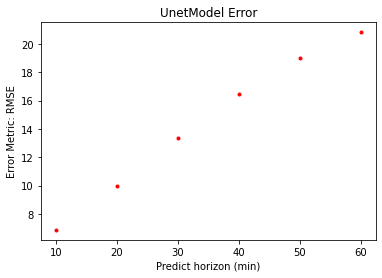

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/' , in_channel = 3, out_channel=6)
val_loader = DataLoader(val_mvd)

load_path = 'checkpoints/model_epoch50_15-06-2021_17_47.pt'
model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

print('Predicting Unet')
time.sleep(1)
error_array_Unet = evaluate.evaluate_model(model_Unet, val_loader, 6, device=device, metric='RMSE')

error_mean_Unet = np.mean(error_array_Unet, axis=0)
print(f'error_array_Unet: {error_mean_Unet}')
visualization.plot_graph(error_mean_Unet, model='Unet')

using device: cuda


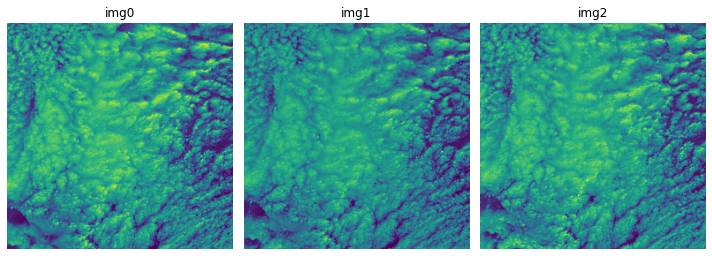

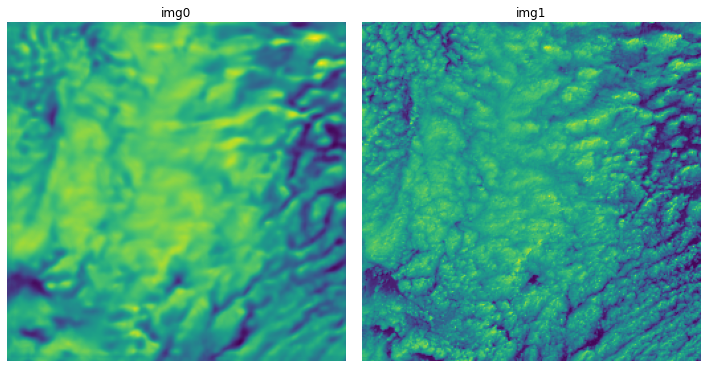

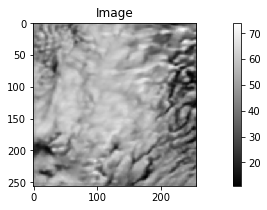

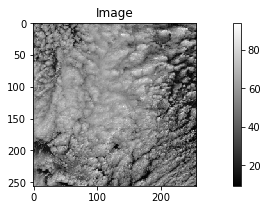

In [9]:
#Visualize predictions
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

load_path = 'checkpoints/model_epoch50_15-06-2021_17_47.pt'
model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/' , in_channel = 3, out_channel=6)
val_loader = DataLoader(val_mvd, shuffle=True)

for idx, (inputs, target) in enumerate(val_loader):
    inputs = inputs.to(device=device)
    prediction = model_Unet(inputs)
    visualization.show_image_list(inputs.cpu().detach().numpy().squeeze(), 1)
    visualization.show_image_list([prediction.cpu().detach().numpy().squeeze(), target.cpu().detach().numpy().squeeze()[0]], 1)
    visualization.show_image_w_colorbar(prediction.cpu().detach().numpy().squeeze())
    visualization.show_image_w_colorbar(target.cpu().detach().numpy().squeeze()[0])
    break

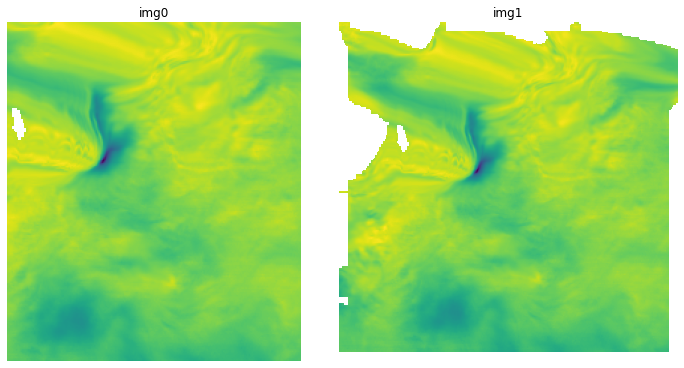

In [7]:
#Display CMV nans problem:
data = np.load('predictions_error.npy')
data2 = np.load('predictions_error_full.npy')
visualization.show_image_list([data,data2], 1)

In [7]:
# Optimize cmv with optuna
def objective(trial):
    #https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af
    dcfg_optuna = {'algorithm': {'cmv': {
        'pyr_scale' : trial.suggest_float("pyr_scale", 0.2, 0.8),
        'levels' : trial.suggest_int("levels", 2, 5),
        'winsize' : trial.suggest_int("winsize", 15, 25),
        'iterations' : trial.suggest_int("iterations", 1, 5),
        'poly_n' : trial.suggest_int("poly_n", 4, 8), # typically poly_n =5 or 7.
        'poly_sigma' : trial.suggest_float("poly_sigma", 0.8, 1.8)}}}

    val_mvd = MontevideoFoldersDataset(path = 'data/mvd/val/', in_channel = 2, out_channel=6)
    val_loader = DataLoader(val_mvd)

    cmv = model.Cmv2(dcfg = dcfg_optuna)
    error = evaluate.evaluate_model(cmv, val_loader, 6, metric='RMSE')
    print(np.mean(error, axis=0))
    return np.mean(error)

study = optuna.create_study()
study.optimize(objective, n_trials=1)

print("\nBest trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-06-11 22:34:40,246] A new study created in memory with name: no-name-8e9e73bb-6b02-4ee8-bb74-0bf92e1b73dc
Status: 100%|██████████| 2488/2488 [01:40<00:00, 24.83sequences/s]
[I 2021-06-11 22:36:20,705] Trial 0 finished with value: 11.185457229614258 and parameters: {'pyr_scale': 0.5672916728664033, 'levels': 2, 'winsize': 24, 'iterations': 5, 'poly_n': 6, 'poly_sigma': 1.7732569892069474}. Best is trial 0 with value: 11.185457229614258.
Cmv predict time: 75.68 seconds.
Evaluation time: 7.09 seconds.
[ 7.3438287  9.484311  11.070971  12.302337  13.124771  13.786546 ]

Best trial:
  Value:  11.185457229614258
  Params: 
    pyr_scale: 0.5672916728664033
    levels: 2
    winsize: 24
    iterations: 5
    poly_n: 6
    poly_sigma: 1.7732569892069474
